# Inicialização

In [1]:
import shapely
!pip install -r requirements.txt


[notice] A new release of pip is available: 23.1.2 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import gtfs_kit as gk
import pandas as pd
import swifter
import seaborn as sns

In [3]:
from pathlib import Path

path = Path("./gtfs_rio-de-janeiro.zip")

feed = gk.read_feed(path, dist_units='km')

feed.validate()

,type,message,table,rows
3,error,Invalid route_type; maybe has extra space char...,routes,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
0,warning,Unrecognized column agency_id,fare_attributes,[]
1,warning,Unrecognized column agency_id,fare_rules,[]
2,warning,Unrecognized column feed_contact_email,feed_info,[]
4,warning,Unrecognized column platform_code,stops,[]


# Parâmetros

In [4]:
route = '309'
position_parquet_file = './309_2023.parquet'
trip_parque_file = './309_2023_viagens.parquet'

# Preparação de dados da rota

In [5]:
route_id = feed.routes[feed.routes['route_short_name'] == route]['route_id'].iloc[0]
route_id

'O0309AAA0A'

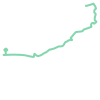

In [6]:
from shapely import LineString, Point

route_geometries = feed.geometrize_routes([route_id], split_directions=True)['geometry']
forwards_geometry: LineString = route_geometries[0]
backwards_geometry: LineString = route_geometries[1]

forwards_geometry

In [7]:
forward_trip = feed.trips[(feed.trips['route_id'] == route_id) & (feed.trips['direction_id'] == 0)].iloc[0]['trip_id']
reverse_trip = feed.trips[(feed.trips['route_id'] == route_id) & (feed.trips['direction_id'] == 1)].iloc[0]['trip_id']
forward_trip, reverse_trip

('8aedc2fc-2ed9-4399-a60d-54501838a81e',
 '8ed81257-ede9-4520-92c8-9d4e77ec6bc6')

In [8]:
forward_trip_stops = feed.stop_times[feed.stop_times['trip_id'] == forward_trip]
backward_trip_stops = feed.stop_times[feed.stop_times['trip_id'] == reverse_trip]

forward_trip_stops['sentido'] = 'I'
backward_trip_stops['sentido'] = 'V'

backward_trip_stops.shape_dist_traveled += forward_trip_stops.shape_dist_traveled.iloc[-1]
backward_trip_stops.stop_sequence += forward_trip_stops.stop_sequence.iloc[-1]

stop_list = pd.concat([forward_trip_stops, backward_trip_stops.iloc[1:]])[['stop_id', 'shape_dist_traveled', 'stop_sequence', 'sentido']]
stop_list['relative_position'] = stop_list['shape_dist_traveled'] / stop_list['shape_dist_traveled'].iloc[-1]
stop_list

C:\Users\thlam\AppData\Local\Temp\ipykernel_23784\449222496.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forward_trip_stops['sentido'] = 'I'
C:\Users\thlam\AppData\Local\Temp\ipykernel_23784\449222496.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  backward_trip_stops['sentido'] = 'V'
C:\Users\thlam\AppData\Local\Temp\ipykernel_23784\449222496.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead



,stop_id,shape_dist_traveled,stop_sequence,sentido,relative_position
622952,wcdt,0.00,0,I,0.000000
622953,4128O00209C0,2935.40,1,I,0.040796
622954,4128O00035C0,3746.88,2,I,0.052074
622955,4128O00036C0,4178.28,3,I,0.058069
622956,4128O00037C0,4710.90,4,I,0.065471
...,...,...,...,...,...
642557,4128O00121C0,68369.50,137,V,0.950191
642558,4128O00122C0,68793.55,138,V,0.956084
642559,4128O00055C0,69229.90,139,V,0.962148
642560,4128O00056C0,69683.61,140,V,0.968454


In [9]:
stop_geometries = feed.geometrize_stops(stop_list['stop_id'])[['stop_id', 'geometry']]

stop_list = pd.merge(stop_list, stop_geometries, on='stop_id')
stop_list.set_index('stop_sequence', inplace=True)
stop_list.sort_values('relative_position', inplace=True)
stop_list

,stop_id,shape_dist_traveled,sentido,relative_position,geometry
stop_sequence,,,,,
0,wcdt,0.00,I,0.000000,POINT (-43.36520 -23.00147)
1,4128O00209C0,2935.40,I,0.040796,POINT (-43.36633 -23.00904)
2,4128O00035C0,3746.88,I,0.052074,POINT (-43.36793 -23.01099)
3,4128O00036C0,4178.28,I,0.058069,POINT (-43.36461 -23.01085)
4,4128O00037C0,4710.90,I,0.065471,POINT (-43.35939 -23.01065)
...,...,...,...,...,...
137,4128O00121C0,68369.50,V,0.950191,POINT (-43.35994 -23.01039)
138,4128O00122C0,68793.55,V,0.956084,POINT (-43.36371 -23.01049)
139,4128O00055C0,69229.90,V,0.962148,POINT (-43.36601 -23.00861)


# Preparação de dados de ônibus

In [10]:
bus_positions = pd.read_parquet(position_parquet_file)
bus_positions.timestamp_gps = pd.to_datetime(bus_positions.timestamp_gps)
bus_positions

,timestamp_gps,latitude,longitude,velocidade_instantanea,velocidade_estimada_10_min,id_veiculo
0,2023-09-11 21:38:09,-22.99241,-43.25229,0,27.9,A41163
1,2023-09-11 10:42:11,-22.90465,-43.19259,0,2.8,A41248
2,2023-07-31 09:08:46,-22.99254,-43.25152,0,35.9,A41053
3,2023-07-31 09:37:16,-22.95230,-43.18678,0,13.0,A41053
4,2023-07-31 16:59:46,-22.96065,-43.20704,0,9.6,A41053
...,...,...,...,...,...,...
34383788,2023-02-15 07:29:55,-23.00712,-43.31080,0,18.1,C41430
34383789,2023-02-18 02:57:56,-23.01053,-43.36566,32,19.1,C41430
34383790,2023-04-06 08:17:58,-23.00730,-43.30674,53,18.1,C41430
34383791,2023-04-13 12:04:14,-23.00146,-43.36593,16,12.6,C41430


In [11]:
bus_positions.sort_values('timestamp_gps', inplace=True)
bus_positions.reset_index(drop=True, inplace=True)
bus_positions.drop_duplicates(subset=['id_veiculo', 'timestamp_gps'], inplace=True, keep='last')
bus_positions

,timestamp_gps,latitude,longitude,velocidade_instantanea,velocidade_estimada_10_min,id_veiculo
0,2023-01-01 00:00:01,-22.87554,-43.24146,0,0.2,C41424
1,2023-01-01 00:00:14,-22.94561,-43.18253,0,29.5,C41265
2,2023-01-01 00:00:26,-23.00025,-43.35741,50,15.9,A41104
3,2023-01-01 00:00:26,-22.87532,-43.24192,0,0.0,A41278
4,2023-01-01 00:00:31,-22.87554,-43.24146,0,0.2,C41424
...,...,...,...,...,...,...
34383788,2023-11-01 23:59:55,-22.90461,-43.19255,0,20.5,C41021
34383789,2023-11-01 23:59:56,-22.90462,-43.19244,0,14.5,A41016
34383790,2023-11-01 23:59:58,-22.90553,-43.18277,26,14.1,A41190
34383791,2023-11-01 23:59:59,-22.99909,-43.24826,43,34.0,A41463


In [12]:
bus_trips = pd.read_parquet(trip_parque_file)
bus_trips.datetime_chegada = pd.to_datetime(bus_trips.datetime_chegada)
bus_trips.datetime_partida = pd.to_datetime(bus_trips.datetime_partida)
bus_trips.sort_values(by='datetime_partida', inplace=True)
bus_trips.reset_index(inplace=True, names='trip_id')
bus_trips

,trip_id,datetime_partida,datetime_chegada,id_veiculo,sentido,tempo_viagem
0,6339,2023-01-01 05:00:22,2023-01-01 05:55:22,C41054,I,56
1,6346,2023-01-01 05:42:45,2023-01-01 06:47:15,C41215,I,66
2,6324,2023-01-01 06:46:39,2023-01-01 07:57:09,A41282,I,72
3,6331,2023-01-01 07:04:50,2023-01-01 08:10:50,C41010,I,67
4,6335,2023-01-01 07:21:04,2023-01-01 08:22:34,C41021,I,62
...,...,...,...,...,...,...
63387,33949,2023-07-30 22:37:12,2023-07-30 23:39:42,C41385,I,63
63388,33795,2023-07-30 22:55:23,2023-07-30 23:54:53,A41016,I,60
63389,33868,2023-07-30 23:11:43,2023-07-31 00:19:13,A41457,I,69
63390,33809,2023-07-30 23:25:41,2023-07-31 00:26:41,A41125,I,62


In [13]:
merged_df = pd.merge_asof(bus_positions, bus_trips, by='id_veiculo', left_on='timestamp_gps', right_on='datetime_partida', direction='backward')
merged_df = merged_df[(merged_df['timestamp_gps'] >= merged_df['datetime_partida']) &
                      (merged_df['timestamp_gps'] <= merged_df['datetime_chegada'])]
bus_positions = merged_df.sort_values(['id_veiculo', 'timestamp_gps'])
bus_positions.reset_index(drop=True, inplace=True)
bus_positions

,timestamp_gps,latitude,longitude,velocidade_instantanea,velocidade_estimada_10_min,id_veiculo,trip_id,datetime_partida,datetime_chegada,sentido,tempo_viagem
0,2023-01-21 15:30:23,-22.90116,-43.18919,21,8.3,A41002,13788.0,2023-01-21 15:30:23,2023-01-21 16:48:53,V,79.0
1,2023-01-21 15:30:53,-22.90051,-43.18815,14,9.0,A41002,13788.0,2023-01-21 15:30:23,2023-01-21 16:48:53,V,79.0
2,2023-01-21 15:31:23,-22.90031,-43.18695,31,9.6,A41002,13788.0,2023-01-21 15:30:23,2023-01-21 16:48:53,V,79.0
3,2023-01-21 15:31:53,-22.90179,-43.18496,10,11.4,A41002,13788.0,2023-01-21 15:30:23,2023-01-21 16:48:53,V,79.0
4,2023-01-21 15:32:23,-22.90200,-43.18444,20,11.1,A41002,13788.0,2023-01-21 15:30:23,2023-01-21 16:48:53,V,79.0
...,...,...,...,...,...,...,...,...,...,...,...
10306442,2023-07-25 21:07:48,-22.90116,-43.17926,26,27.4,C41430,61081.0,2023-07-25 20:04:29,2023-07-25 21:10:48,I,67.0
10306443,2023-07-25 21:08:18,-22.90138,-43.18009,21,26.8,C41430,61081.0,2023-07-25 20:04:29,2023-07-25 21:10:48,I,67.0
10306444,2023-07-25 21:08:48,-22.90224,-43.18263,38,28.7,C41430,61081.0,2023-07-25 20:04:29,2023-07-25 21:10:48,I,67.0
10306445,2023-07-25 21:09:18,-22.90330,-43.18600,46,28.4,C41430,61081.0,2023-07-25 20:04:29,2023-07-25 21:10:48,I,67.0


# Cálculo de localização

## Localização relativa do ônibus na rota

In [14]:
def to_point(row):
    return Point(row['longitude'], row['latitude'])
bus_positions['geometry'] = bus_positions[['latitude', 'longitude']].swifter.apply(to_point, axis=1)
bus_positions

Pandas Apply:   0%|          | 0/10306447 [00:00<?, ?it/s]

,timestamp_gps,latitude,longitude,velocidade_instantanea,velocidade_estimada_10_min,id_veiculo,trip_id,datetime_partida,datetime_chegada,sentido,tempo_viagem,geometry
0,2023-01-21 15:30:23,-22.90116,-43.18919,21,8.3,A41002,13788.0,2023-01-21 15:30:23,2023-01-21 16:48:53,V,79.0,POINT (-43.18919 -22.90116)
1,2023-01-21 15:30:53,-22.90051,-43.18815,14,9.0,A41002,13788.0,2023-01-21 15:30:23,2023-01-21 16:48:53,V,79.0,POINT (-43.18815 -22.90051)
2,2023-01-21 15:31:23,-22.90031,-43.18695,31,9.6,A41002,13788.0,2023-01-21 15:30:23,2023-01-21 16:48:53,V,79.0,POINT (-43.18695 -22.90031)
3,2023-01-21 15:31:53,-22.90179,-43.18496,10,11.4,A41002,13788.0,2023-01-21 15:30:23,2023-01-21 16:48:53,V,79.0,POINT (-43.18496 -22.90179)
4,2023-01-21 15:32:23,-22.90200,-43.18444,20,11.1,A41002,13788.0,2023-01-21 15:30:23,2023-01-21 16:48:53,V,79.0,POINT (-43.18444 -22.902)
...,...,...,...,...,...,...,...,...,...,...,...,...
10306442,2023-07-25 21:07:48,-22.90116,-43.17926,26,27.4,C41430,61081.0,2023-07-25 20:04:29,2023-07-25 21:10:48,I,67.0,POINT (-43.17926 -22.90116)
10306443,2023-07-25 21:08:18,-22.90138,-43.18009,21,26.8,C41430,61081.0,2023-07-25 20:04:29,2023-07-25 21:10:48,I,67.0,POINT (-43.18009 -22.90138)
10306444,2023-07-25 21:08:48,-22.90224,-43.18263,38,28.7,C41430,61081.0,2023-07-25 20:04:29,2023-07-25 21:10:48,I,67.0,POINT (-43.18263 -22.90224)
10306445,2023-07-25 21:09:18,-22.90330,-43.18600,46,28.4,C41430,61081.0,2023-07-25 20:04:29,2023-07-25 21:10:48,I,67.0,POINT (-43.186 -22.9033)


In [15]:
total_geometry_length = forwards_geometry.length + backwards_geometry.length

forwards_bus_positions = bus_positions[bus_positions['sentido'] == 'I']
forwards_bus_projections = forwards_geometry.project(forwards_bus_positions['geometry'])
forwards_bus_interpolations = forwards_geometry.interpolate(forwards_bus_projections)
forwards_bus_final_projection = forwards_geometry.project(forwards_bus_interpolations)
forwards_bus_roundtrip_locations = forwards_bus_final_projection / total_geometry_length
forwards_bus_locations = forwards_bus_final_projection / forwards_geometry.length

backwards_bus_positions = bus_positions[bus_positions['sentido'] == 'V']
backwards_bus_projections = backwards_geometry.project(backwards_bus_positions['geometry'])
backwards_bus_interpolations = backwards_geometry.interpolate(backwards_bus_projections)
backwards_bus_final_projection = backwards_geometry.project(backwards_bus_interpolations)
backwards_bus_roundtrip_locations = (backwards_bus_final_projection + forwards_geometry.length) / total_geometry_length
backwards_bus_locations = backwards_bus_final_projection / backwards_geometry.length

bus_positions['relative_roundtrip_distance'] = pd.concat([forwards_bus_roundtrip_locations, backwards_bus_roundtrip_locations])
bus_positions['relative_distance'] = pd.concat([forwards_bus_locations, backwards_bus_locations])
bus_positions

,timestamp_gps,latitude,longitude,velocidade_instantanea,velocidade_estimada_10_min,id_veiculo,trip_id,datetime_partida,datetime_chegada,sentido,tempo_viagem,geometry,relative_roundtrip_distance,relative_distance
0,2023-01-21 15:30:23,-22.90116,-43.18919,21,8.3,A41002,13788.0,2023-01-21 15:30:23,2023-01-21 16:48:53,V,79.0,POINT (-43.18919 -22.90116),0.508194,0.017065
1,2023-01-21 15:30:53,-22.90051,-43.18815,14,9.0,A41002,13788.0,2023-01-21 15:30:23,2023-01-21 16:48:53,V,79.0,POINT (-43.18815 -22.90051),0.509991,0.020657
2,2023-01-21 15:31:23,-22.90031,-43.18695,31,9.6,A41002,13788.0,2023-01-21 15:30:23,2023-01-21 16:48:53,V,79.0,POINT (-43.18695 -22.90031),0.512295,0.025263
3,2023-01-21 15:31:53,-22.90179,-43.18496,10,11.4,A41002,13788.0,2023-01-21 15:30:23,2023-01-21 16:48:53,V,79.0,POINT (-43.18496 -22.90179),0.515924,0.032515
4,2023-01-21 15:32:23,-22.90200,-43.18444,20,11.1,A41002,13788.0,2023-01-21 15:30:23,2023-01-21 16:48:53,V,79.0,POINT (-43.18444 -22.902),0.516765,0.034197
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10306442,2023-07-25 21:07:48,-22.90116,-43.17926,26,27.4,C41430,61081.0,2023-07-25 20:04:29,2023-07-25 21:10:48,I,67.0,POINT (-43.17926 -22.90116),0.476072,0.952802
10306443,2023-07-25 21:08:18,-22.90138,-43.18009,21,26.8,C41430,61081.0,2023-07-25 20:04:29,2023-07-25 21:10:48,I,67.0,POINT (-43.18009 -22.90138),0.477393,0.955445
10306444,2023-07-25 21:08:48,-22.90224,-43.18263,38,28.7,C41430,61081.0,2023-07-25 20:04:29,2023-07-25 21:10:48,I,67.0,POINT (-43.18263 -22.90224),0.481319,0.963303
10306445,2023-07-25 21:09:18,-22.90330,-43.18600,46,28.4,C41430,61081.0,2023-07-25 20:04:29,2023-07-25 21:10:48,I,67.0,POINT (-43.186 -22.9033),0.486508,0.973688


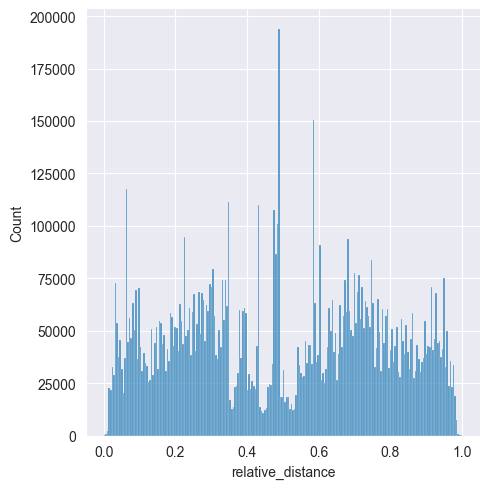

In [16]:
sns.displot(bus_positions['relative_distance'])

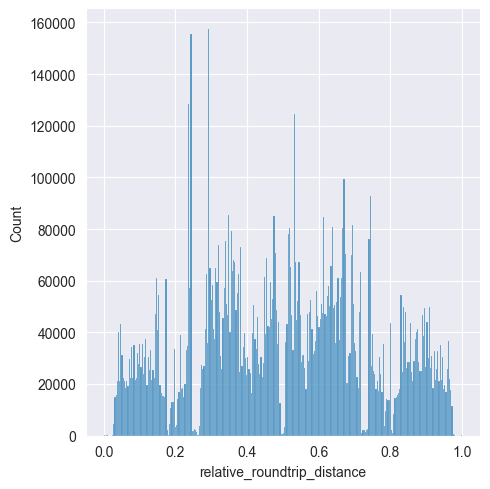

In [17]:
sns.displot(bus_positions['relative_roundtrip_distance'])

## Parada onde o ônibus está

In [18]:
bus_positions['next_stop_index'] = stop_list['relative_position'].searchsorted(bus_positions['relative_roundtrip_distance'], side='left')
bus_positions['previous_stop_index'] = bus_positions['next_stop_index'] - 1
bus_positions.loc[bus_positions['previous_stop_index'] == -1, 'previous_stop_index'] = 0
bus_positions

,timestamp_gps,latitude,longitude,velocidade_instantanea,velocidade_estimada_10_min,id_veiculo,trip_id,datetime_partida,datetime_chegada,sentido,tempo_viagem,geometry,relative_roundtrip_distance,relative_distance,next_stop_index,previous_stop_index
0,2023-01-21 15:30:23,-22.90116,-43.18919,21,8.3,A41002,13788.0,2023-01-21 15:30:23,2023-01-21 16:48:53,V,79.0,POINT (-43.18919 -22.90116),0.508194,0.017065,70,69
1,2023-01-21 15:30:53,-22.90051,-43.18815,14,9.0,A41002,13788.0,2023-01-21 15:30:23,2023-01-21 16:48:53,V,79.0,POINT (-43.18815 -22.90051),0.509991,0.020657,70,69
2,2023-01-21 15:31:23,-22.90031,-43.18695,31,9.6,A41002,13788.0,2023-01-21 15:30:23,2023-01-21 16:48:53,V,79.0,POINT (-43.18695 -22.90031),0.512295,0.025263,70,69
3,2023-01-21 15:31:53,-22.90179,-43.18496,10,11.4,A41002,13788.0,2023-01-21 15:30:23,2023-01-21 16:48:53,V,79.0,POINT (-43.18496 -22.90179),0.515924,0.032515,71,70
4,2023-01-21 15:32:23,-22.90200,-43.18444,20,11.1,A41002,13788.0,2023-01-21 15:30:23,2023-01-21 16:48:53,V,79.0,POINT (-43.18444 -22.902),0.516765,0.034197,71,70
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10306442,2023-07-25 21:07:48,-22.90116,-43.17926,26,27.4,C41430,61081.0,2023-07-25 20:04:29,2023-07-25 21:10:48,I,67.0,POINT (-43.17926 -22.90116),0.476072,0.952802,67,66
10306443,2023-07-25 21:08:18,-22.90138,-43.18009,21,26.8,C41430,61081.0,2023-07-25 20:04:29,2023-07-25 21:10:48,I,67.0,POINT (-43.18009 -22.90138),0.477393,0.955445,67,66
10306444,2023-07-25 21:08:48,-22.90224,-43.18263,38,28.7,C41430,61081.0,2023-07-25 20:04:29,2023-07-25 21:10:48,I,67.0,POINT (-43.18263 -22.90224),0.481319,0.963303,68,67
10306445,2023-07-25 21:09:18,-22.90330,-43.18600,46,28.4,C41430,61081.0,2023-07-25 20:04:29,2023-07-25 21:10:48,I,67.0,POINT (-43.186 -22.9033),0.486508,0.973688,68,67


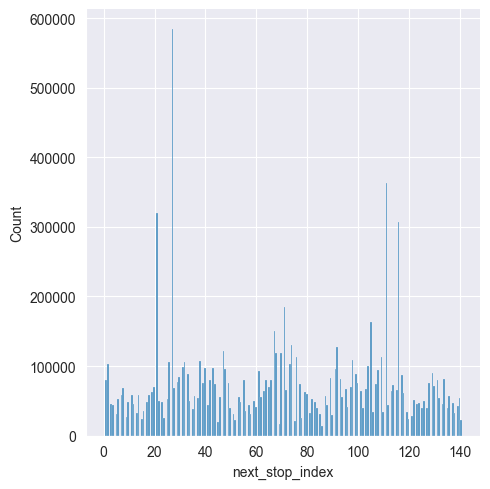

In [19]:
sns.displot(bus_positions['next_stop_index'])

## Distância do ônibus até a rota

In [20]:
forwards_bus_distances = forwards_geometry.distance(forwards_bus_positions['geometry'])
backwards_bus_distances = backwards_geometry.distance(backwards_bus_positions['geometry'])

bus_positions['distance_from_route'] = pd.concat([forwards_bus_distances, backwards_bus_distances])
bus_positions

,timestamp_gps,latitude,longitude,velocidade_instantanea,velocidade_estimada_10_min,id_veiculo,trip_id,datetime_partida,datetime_chegada,sentido,tempo_viagem,geometry,relative_roundtrip_distance,relative_distance,next_stop_index,previous_stop_index,distance_from_route
0,2023-01-21 15:30:23,-22.90116,-43.18919,21,8.3,A41002,13788.0,2023-01-21 15:30:23,2023-01-21 16:48:53,V,79.0,POINT (-43.18919 -22.90116),0.508194,0.017065,70,69,0.000042
1,2023-01-21 15:30:53,-22.90051,-43.18815,14,9.0,A41002,13788.0,2023-01-21 15:30:23,2023-01-21 16:48:53,V,79.0,POINT (-43.18815 -22.90051),0.509991,0.020657,70,69,0.000053
2,2023-01-21 15:31:23,-22.90031,-43.18695,31,9.6,A41002,13788.0,2023-01-21 15:30:23,2023-01-21 16:48:53,V,79.0,POINT (-43.18695 -22.90031),0.512295,0.025263,70,69,0.000072
3,2023-01-21 15:31:53,-22.90179,-43.18496,10,11.4,A41002,13788.0,2023-01-21 15:30:23,2023-01-21 16:48:53,V,79.0,POINT (-43.18496 -22.90179),0.515924,0.032515,71,70,0.000014
4,2023-01-21 15:32:23,-22.90200,-43.18444,20,11.1,A41002,13788.0,2023-01-21 15:30:23,2023-01-21 16:48:53,V,79.0,POINT (-43.18444 -22.902),0.516765,0.034197,71,70,0.000021
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10306442,2023-07-25 21:07:48,-22.90116,-43.17926,26,27.4,C41430,61081.0,2023-07-25 20:04:29,2023-07-25 21:10:48,I,67.0,POINT (-43.17926 -22.90116),0.476072,0.952802,67,66,0.000040
10306443,2023-07-25 21:08:18,-22.90138,-43.18009,21,26.8,C41430,61081.0,2023-07-25 20:04:29,2023-07-25 21:10:48,I,67.0,POINT (-43.18009 -22.90138),0.477393,0.955445,67,66,0.000137
10306444,2023-07-25 21:08:48,-22.90224,-43.18263,38,28.7,C41430,61081.0,2023-07-25 20:04:29,2023-07-25 21:10:48,I,67.0,POINT (-43.18263 -22.90224),0.481319,0.963303,68,67,0.000101
10306445,2023-07-25 21:09:18,-22.90330,-43.18600,46,28.4,C41430,61081.0,2023-07-25 20:04:29,2023-07-25 21:10:48,I,67.0,POINT (-43.186 -22.9033),0.486508,0.973688,68,67,0.000038


## Exportando arquivos para análise

In [109]:
bus_trips.to_pickle("bus_trips.pickle")
bus_positions.to_pickle("bus_positions.pickle")
stop_list.to_pickle("stop_list.pickle")